In [ ]:
%cd /content
!pip install optuna

/content
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 18.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 7.1 MB/s eta 0:00:00


In [ ]:
import time
import warnings
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt

from tqdm import tqdm
from sklearn.metrics import *
from itertools import product
from sklearn.preprocessing import *
from matplotlib.backends.backend_pdf import PdfPages
from sklearn.model_selection import train_test_split, KFold

In [ ]:
class Colors:
    RESET = "\033[0m"  # Reset to default color
    RED = "\033[31m"   # Red
    GREEN = "\033[32m" # Green
    YELLOW = "\033[33m" # Yellow
    BLUE = "\033[34m"  # Blue
    MAGENTA = "\033[35m" # Magenta
    CYAN = "\033[36m"  # Cyan
    WHITE = "\033[37m" # White

class Styles:
    RESET = "\033[0m"   # Reset to default
    BOLD = "\033[1m"    # Bold
    ITALIC = "\033[3m"  # Italic

def print_pretty(msg = 'Empty', color=Colors.RED, style=None):
  if not style:
    print(color + msg + Colors.RESET)
  else:
    print(style + color + msg + Colors.RESET + Styles.RESET)

def binning_binary(value):
  if value == 0:
    return 0
  return 1

def binning_classification(value):
  if 0 < value < 1:
    return 'Very Light Rain'
  elif value < 11:
    return 'Light Rain'
  elif value < 31:
    return 'Moderate Rain'
  elif value < 71:
    return 'Heavy Rain'
  elif value < 151:
    return 'Very Heavy Rain'
  else:
    return 'Extremely Heavy Rain'
  return 'Invalid value'

def binning_to_scalar(value):
    if 0 <= value < 1:
      return 0  # Very Light Rain
    elif value < 11:
      return 1  # Light Rain
    elif value < 31:
      return 2  # Moderate Rain
    elif value < 71:
      return 3  # Heavy Rain
    elif value < 151:
      return 4  # Very Heavy Rain
    elif value >= 151:
      return 5  # Extremely Heavy Rain


In [ ]:
def binary_classification(
    dtrain,
    ddev,
    learning_rate,
    scale_pos_weight,
    max_depth,
    epoch,
    early_stopping_rounds=10
    ):

    params = {
        'objective': 'binary:logistic',
        'tree_method': 'hist',
        'scale_pos_weight': scale_pos_weight,
        'device': 'cuda',
        'eval_metric': ['logloss', 'auc'],
        'eta': learning_rate,
        'max_depth': max_depth,
    }
    model = xgb.train(params,
                      dtrain,
                      num_boost_round=epoch,
                      verbose_eval=False)
    return model

def multiclass_classification(
    dtrain,
    ddev,
    learning_rate,
    max_depth,
    epoch,
    early_stopping_rounds=10,
    lambda_val=1.0,
    alpha_val=0.5,
    subsample=0.5,
    colsample_bytree=0.5
    ):

    params = {
        'objective': 'multi:softprob',  # Multi-class classification
        'tree_method': 'hist',  # Use GPU
        'device': 'cuda',  # Running on GPU
        'eval_metric': ['mlogloss', 'merror'],  # Multi-class log loss
        'eta': learning_rate,  # Learning rate
        'max_depth': max_depth,  # Maximum depth of trees
        'lambda': lambda_val,  # L2 regularization
        'alpha': alpha_val,  # L1 regularization
        'num_class': 6,  # Number of classes (adjust as needed)
        'subsample': subsample,  # Subsample for each tree
        'colsample_bytree': colsample_bytree  # Fraction of features for each tree
    }
    evals = [(dtrain, 'train'), (ddev, 'eval')]
    evals_result = {}

    model = xgb.train(params,
                      dtrain,
                      num_boost_round=epoch,
                      early_stopping_rounds=early_stopping_rounds,
                      evals=evals,
                      evals_result=evals_result,
                      verbose_eval=False)
    return model

def linear_regression(
    dtrain,
    ddev,
    learning_rate,
    max_depth,
    epoch,
    lambda_val=1.0,
    alpha_val=0.5,
    early_stopping_rounds=10,
    colsample_bytree=0.8,
    colsample_bylevel=0.8,
    colsample_bynode=0.8,
    subsample=0.8,
    min_child_weight=1,
    gamma=0.5,
    max_delta_step=1
    ):

    params = {
        'objective': 'reg:squarederror',  # For linear regression
        'tree_method': 'hist',  # Enable GPU
        'device': 'cuda',
        'eval_metric': 'rmse',  # Evaluation metric for regression
        'eta': learning_rate,  # Learning rate
        'max_depth': max_depth,  # Maximum tree depth
        'lambda': lambda_val,  # L2 regularization
        'alpha': alpha_val,  # L1 regularization
        'colsample_bytree': colsample_bytree,
        'colsample_bylevel': colsample_bylevel,
        'colsample_bynode': colsample_bynode,
        'subsample': subsample,
        'min_child_weight': min_child_weight,
        'gamma': gamma,
        'max_delta_step': max_delta_step,
    }

    evals = [(dtrain, 'train'), (ddev, 'eval')]
    evals_result = {}

    model = xgb.train(params,
                      dtrain,
                      num_boost_round=epoch,
                      early_stopping_rounds=early_stopping_rounds,
                      evals=evals,
                      evals_result=evals_result,
                      verbose_eval=False)

    return model

In [ ]:
seed = 42
np.random.seed(seed)

train_data = pd.read_csv('train_data.csv')
test_data = pd.read_csv('test_data.csv')
train_data = pd.DataFrame(train_data)
test_data = pd.DataFrame(test_data)
train_data = train_data.dropna()
test_data = test_data.dropna()

features = ['cape', 'cin', 'ewss', 'ie', 'isor', 'kx', 'pev', 'slhf', 'slor', 'sshf', 'tclw', 'tcw', 'tcwv', 'aws-5', 'aws-4', 'aws-3', 'aws-2', 'aws-1']
target = 'aws'

print(f'Number of training examples: {len(train_data)}')
print(f'Number of features: {len(features)}')

# Data for binary classification
X_train = train_data[features]
y_train = train_data[target]
X_test = test_data[features]
y_test = test_data[target]
y_train_bin = y_train.apply(binning_binary)
y_train_mul = y_train.apply(binning_to_scalar)


## Data for binary
X_train_bin, X_dev_bin, y_train_bin, y_dev_bin = train_test_split(
    X_train, y_train_bin, test_size=0.2, random_state=seed, stratify=y_train_bin)

## Data for Multi-bin
non_zero_indices = y_train != 0
X_train_filtered = X_train[non_zero_indices]
y_train_mul_filtered = y_train_mul[non_zero_indices]
X_train_mul, X_dev_mul, y_train_mul, y_dev_mul = train_test_split(
    X_train_filtered, y_train_mul_filtered, test_size=0.2, random_state=seed, stratify=y_train_mul_filtered)


y_train_filtered = y_train[non_zero_indices]
X_train_reg, X_dev_reg, y_train_reg, y_dev_reg = train_test_split(
    X_train_filtered.assign(**{'encode': y_train_mul_filtered}), y_train_filtered, test_size=0.2, random_state=seed)

scaler = QuantileTransformer( output_distribution='normal', random_state=seed)
target_scaler = QuantileTransformer( output_distribution='normal', random_state=seed)

# Fit and transform the features for X_train and X_test
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

# Scale the X_train_bin and X_dev_bin (based on the same scaler)
X_train_bin = pd.DataFrame(scaler.transform(X_train_bin), columns=X_train_bin.columns)
X_dev_bin = pd.DataFrame(scaler.transform(X_dev_bin), columns=X_dev_bin.columns)

# Scale the X_train_mul and X_dev_mul
X_train_mul = pd.DataFrame(scaler.transform(X_train_mul), columns=X_train_mul.columns)
X_dev_mul = pd.DataFrame(scaler.transform(X_dev_mul), columns=X_dev_mul.columns)

# Scale the X_train_reg and X_dev_reg (excluding 'encode' column)
X_train_reg_scaled = X_train_reg.copy()
X_dev_reg_scaled = X_dev_reg.copy()

# Drop 'encode' column for scaling
X_train_reg_scaled.drop(columns='encode', inplace=True)
X_dev_reg_scaled.drop(columns='encode', inplace=True)

# Apply scaling to the remaining columns
X_train_reg_scaled = pd.DataFrame(scaler.transform(X_train_reg_scaled), columns=X_train_reg_scaled.columns)
X_dev_reg_scaled = pd.DataFrame(scaler.transform(X_dev_reg_scaled), columns=X_dev_reg_scaled.columns)

# Add 'encode' column back to the scaled data
X_train_reg_scaled['encode'] = X_train_reg['encode']
X_dev_reg_scaled['encode'] = X_dev_reg['encode']
X_train_reg = X_train_reg_scaled
X_dev_reg = X_dev_reg_scaled

# Scale the target variables (y_train, y_test, y_train_reg, y_dev_reg)
y_train_scaled = pd.DataFrame(target_scaler.fit_transform(y_train.values.reshape(-1, 1)).flatten(), columns=[target])
y_test_scaled = pd.DataFrame(target_scaler.transform(y_test.values.reshape(-1, 1)).flatten(), columns=[target])
y_train_reg = pd.DataFrame(target_scaler.transform(y_train_reg.values.reshape(-1, 1)).flatten(), columns=[target])
y_dev_reg = pd.DataFrame(target_scaler.transform(y_dev_reg.values.reshape(-1, 1)).flatten(), columns=[target])

C:\Users\ducmi\Anaconda\envs\Aitest\lib\site-packages\IPython\core\magics\osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


C:\Users\ducmi\AIdata
Number of training examples: 190284
Number of features: 18


In [ ]:
from re import sub
import optuna
import gc

def tuning_merge(trial):
    bdtrain = xgb.DMatrix(X_train_bin, label=y_train_bin)
    bddev = xgb.DMatrix(X_dev_bin, label=y_dev_bin)
    bdtest = xgb.DMatrix(X_test_scaled, label=y_test.apply(binning_binary))
    # Hyperparameters to tune
    blearning_rate = trial.suggest_float('blearning_rate', 1e-5, 0.1, log=True)
    bmax_depth = trial.suggest_int('bmax_depth', 3, 20)
    bscale_pos_weight = trial.suggest_int('bscale_pos_weight', 1, 10)
    bepoch = 4000
    bthreshold = trial.suggest_float('bthreshold', 0.0, 1.0)

    # Train the model using the provided parameters
    model_bin = binary_classification(bdtrain, bddev, blearning_rate, bscale_pos_weight, bmax_depth, bepoch)
    y_pred_prob = model_bin.predict(bdtest)
    y_pred_binary = (y_pred_prob > bthreshold).astype(int)
    bin_index = np.where(y_pred_binary == 1)[0]
    if len(bin_index) == 0:
      raise optuna.exceptions.TrialPruned(f"Trial pruned because no indices matched the condition (y_pred_binary == 1).")

    mdtrain = xgb.DMatrix(X_train_mul, label=y_train_mul)
    mddev = xgb.DMatrix(X_dev_mul, label=y_dev_mul)
    mdtest = xgb.DMatrix(X_test_scaled.iloc[bin_index], label=y_test.apply(binning_to_scalar).iloc[bin_index])
    # Hyperparameters to tune
    mlearning_rate = trial.suggest_float('mlearning_rate', 1e-5, 0.1, log=True)
    mmax_depth = trial.suggest_int('mmax_depth', 3, 20)
    mlambda_val = trial.suggest_float('mlambda', 0.1, 1.0)
    malpha_val = trial.suggest_float('malpha', 0.1, 1.0)
    mepoch = 4000
    msubsample = trial.suggest_float('msubsample', 0.7, 1.0)
    mcolsample_bytree = trial.suggest_float('mcolsample_bytree', 0.7, 1.0)

    # Train the model using the provided parameters
    model = multiclass_classification(
        mdtrain, mddev,
        learning_rate=mlearning_rate,
        max_depth=mmax_depth,
        epoch=mepoch,
        lambda_val=mlambda_val,
        alpha_val=malpha_val,
        subsample=msubsample,
        colsample_bytree=mcolsample_bytree)

    y_pred_prob = model.predict(mdtest)
    y_pred_multi = y_pred_prob.argmax(axis=1)

    rtrain = xgb.DMatrix(X_train_reg, label=y_train_reg)
    rdev = xgb.DMatrix(X_dev_reg, label=y_dev_reg)
    rdtest = xgb.DMatrix(X_test_scaled.iloc[bin_index].assign(**{'encode': y_pred_multi}), label=y_test_scaled.iloc[bin_index])
    # Hyperparameters to tune
    learning_rate = trial.suggest_float('rlearning_rate', 1e-3, 0.1, log=True)
    max_depth = trial.suggest_int('rmax_depth', 3, 20)
    epoch = 4000
    lambda_val = trial.suggest_float('rlambda_val', 1e-5, 1.0, log=True)  # L2 regularization
    alpha_val = trial.suggest_float('ralpha_val', 1e-5, 1.0, log=True)  # L1 regularization
    colsample_bytree = trial.suggest_float('rcolsample_bytree', 0.5, 1.0)
    colsample_bylevel = trial.suggest_float('rcolsample_bylevel', 0.5, 1.0)
    colsample_bynode = trial.suggest_float('rcolsample_bynode', 0.5, 1.0)
    subsample = trial.suggest_float('rsubsample', 0.5, 1.0)
    min_child_weight = trial.suggest_int('rmin_child_weight', 1, 10)
    gamma = trial.suggest_float('rgamma', 0.0, 1.0)
    max_delta_step = trial.suggest_int('rmax_delta_step', 0, 10)

    # Train the model using the provided parameters
    model_reg = linear_regression(
        rtrain, rdev, learning_rate=learning_rate,
        max_depth=max_depth, epoch=epoch,
        lambda_val=lambda_val, alpha_val=alpha_val,
        colsample_bytree=colsample_bytree, colsample_bylevel=colsample_bylevel,
        colsample_bynode=colsample_bynode, subsample=subsample,
        min_child_weight=min_child_weight, gamma=gamma,
        max_delta_step=max_delta_step
    )

    y_pred_reg = model_reg.predict(rdtest)

    y_pred_reg_original = target_scaler.inverse_transform(y_pred_reg.reshape(-1, 1)).flatten()
    y_pred_reg_original_full = np.zeros(len(y_test))
    y_pred_reg_original_full[bin_index] = y_pred_reg_original

    rmse = np.sqrt(mean_squared_error(y_test, y_pred_reg_original_full))
    r2 = r2_score(y_test, y_pred_reg_original_full)
    mae = mean_absolute_error(y_test, y_pred_reg_original_full)
    return r2

study = optuna.create_study(
    direction='maximize',
    storage="sqlite:///optuna_study.db",
    load_if_exists=True
)
study.optimize(tuning_merge, n_trials=100, n_jobs=4, gc_after_trial=True)

# Get the best hyperparameters from the study
best_params = study.best_params
print(f"Best Hyperparameters: {best_params}")

C:\Users\ducmi\Anaconda\envs\Aitest\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2024-12-03 14:23:19,892] A new study created in RDB with name: no-name-ab54d9cc-f85d-44b2-b9dc-69f2403e4fd8


In [ ]:
best_params = {'blearning_rate': 0.057004991591952096, 'bmax_depth': 16, 'bscale_pos_weight': 8, 'bthreshold': 0.6632235881447962, 'mlearning_rate': 0.009311523909940028, 'mmax_depth': 3, 'mlambda': 0.9710902257011625, 'malpha': 0.7319625765360483, 'msubsample': 0.9290857411444926, 'mcolsample_bytree': 0.9154848883052178, 'rlearning_rate': 0.018645667571316745, 'rmax_depth': 15, 'rlambda_val': 0.0014689646265986886, 'ralpha_val': 3.197744539316868e-05, 'rcolsample_bytree': 0.5491966370123315, 'rcolsample_bylevel': 0.9125902099594034, 'rcolsample_bynode': 0.6552733943590697, 'rsubsample': 0.5382617343947838, 'rmin_child_weight': 5, 'rgamma': 0.11778684336647949, 'rmax_delta_step': 6}
bdtrain = xgb.DMatrix(X_train_bin, label=y_train_bin)
bddev = xgb.DMatrix(X_dev_bin, label=y_dev_bin)
bdtest = xgb.DMatrix(X_test_scaled, label=y_test.apply(binning_binary))

lr = best_params['blearning_rate']
depth = best_params['bmax_depth']
weight = best_params['bscale_pos_weight']
epoch = 4000
thresh_hold = best_params['bthreshold']

model_binary = binary_classification(bdtrain, bddev, lr, weight, depth, epoch)
y_pred_prob = model_binary.predict(bdtest)
y_pred_binary = (y_pred_prob > thresh_hold).astype(int)

accuracy = accuracy_score(bdtest.get_label(), y_pred_binary)
precision = precision_score(bdtest.get_label(), y_pred_binary)
recall = recall_score(bdtest.get_label(), y_pred_binary)
f1 = f1_score(bdtest.get_label(), y_pred_binary)
print_pretty(msg=f'Accuracy: {accuracy} - Precision: {precision} - Recall: {recall} - F1: {f1}', color = Colors.GREEN)

bin_index = np.where(y_pred_binary == 1)[0]

Accuracy: 0.9345609720207689 - Precision: 0.6907150480256137 - Recall: 0.6604081632653062 - F1: 0.6752217005738133


In [ ]:
mdtrain = xgb.DMatrix(X_train_mul, label=y_train_mul)
mddev = xgb.DMatrix(X_dev_mul, label=y_dev_mul)
mdtest = xgb.DMatrix(X_test_scaled.iloc[bin_index], label=y_test.apply(binning_to_scalar).iloc[bin_index])

learning_rate = best_params['mlearning_rate']
max_depth = best_params['mmax_depth']
lambda_val = best_params['mlambda']
alpha_val = best_params['malpha']
epoch = 4000
subsample = best_params['msubsample']
colsample_bytree = best_params['mcolsample_bytree']

model_multi = multiclass_classification(mdtrain, mddev, learning_rate, max_depth, epoch, lambda_val=lambda_val, alpha_val=alpha_val, subsample=subsample, colsample_bytree=colsample_bytree)
y_pred_prob = model_multi.predict(mdtest)
y_pred_multi = y_pred_prob.argmax(axis=1)

accuracy = accuracy_score(mdtest.get_label(), y_pred_multi)
precision = precision_score(mdtest.get_label(), y_pred_multi, average='weighted')
recall = recall_score(mdtest.get_label(), y_pred_multi, average='weighted')
f1 = f1_score(mdtest.get_label(), y_pred_multi, average='weighted')
print_pretty(msg=f'Accuracy: {accuracy} - Precision: {precision} - Recall: {recall} - F1: {f1}', color=Colors.GREEN)

Accuracy: 0.7244397011739594 - Precision: 0.7281723813985862 - Recall: 0.7244397011739594 - F1: 0.7170810726665379


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
rtrain = xgb.DMatrix(X_train_reg, label=y_train_reg)
rdev = xgb.DMatrix(X_dev_reg, label=y_dev_reg)
rdtest = xgb.DMatrix(X_test_scaled.iloc[bin_index].assign(**{'encode': y_pred_multi}), label=y_test_scaled.iloc[bin_index])

learning_rate = best_params['rlearning_rate']
max_depth = best_params['rmax_depth']
epoch = 4000
lambda_val = best_params['rlambda_val']
alpha_val = best_params['ralpha_val']
colsample_bytree =  best_params['rcolsample_bytree']
colsample_bylevel = best_params['rcolsample_bylevel']
colsample_bynode = best_params['rcolsample_bynode']
subsample = best_params['rsubsample']
min_child_weight = best_params['rmin_child_weight']
gamma = best_params['rgamma']
max_delta_step = best_params['rmax_delta_step']

# Train the model using the provided parameters
model_reg = linear_regression(
    rtrain, rdev, learning_rate=learning_rate,
    max_depth=max_depth, epoch=epoch,
    lambda_val=lambda_val, alpha_val=alpha_val,
    colsample_bytree=colsample_bytree, colsample_bylevel=colsample_bylevel,
    colsample_bynode=colsample_bynode, subsample=subsample,
    min_child_weight=min_child_weight, gamma=gamma,
    max_delta_step=max_delta_step
)
y_pred_reg = model_reg.predict(rdtest)

y_pred_reg_original = target_scaler.inverse_transform(y_pred_reg.reshape(-1, 1)).flatten()
y_pred_reg_original_full = np.zeros(len(y_test))
y_pred_reg_original_full[bin_index] = y_pred_reg_original

mse = mean_squared_error(y_test, y_pred_reg_original_full)
r2 = r2_score(y_test, y_pred_reg_original_full)
mae = mean_absolute_error(y_test, y_pred_reg_original_full)

print_pretty(msg=f'MSE: {mse:.4f} - R2: {r2:.4f} - MAE: {mae:.4f}', color=Colors.GREEN)

MSE: 3.2085 - R2: 0.4628 - MAE: 0.2882


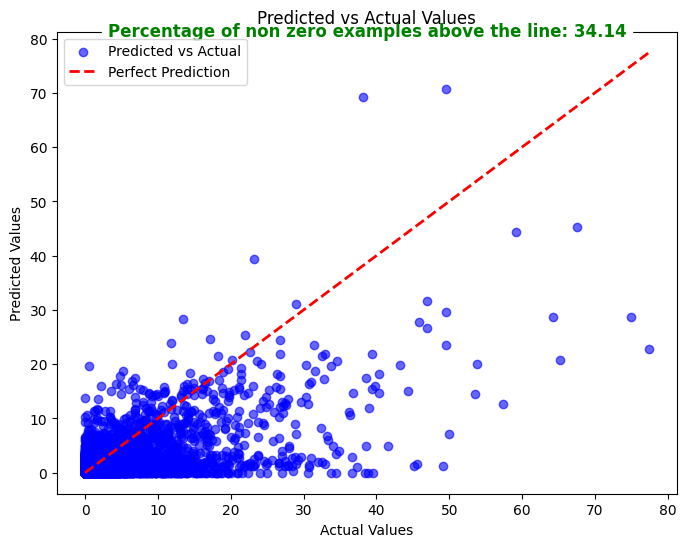

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Create 45-degree line for perfect prediction
perfect_line = np.linspace(min(y_test), max(y_test), 100)

# Create the plot
plt.figure(figsize=(8, 6))

# Plot predicted vs actual values
plt.scatter(y_test, y_pred_reg_original_full, color='blue', alpha=0.6, label='Predicted vs Actual')

# Plot 45-degree line (perfect fit line)
plt.plot(perfect_line, perfect_line, color='red', lw=2, linestyle='--', label='Perfect Prediction')

above_line = y_pred_reg_original_full[y_test!=0] > y_test[y_test!=0]
percentage_above_line = np.mean(above_line) * 100
note_text = f"Percentage of non zero examples above the line: {percentage_above_line:.2f}"
plt.text(0.5, 1, note_text, ha='center', va='center', transform=plt.gca().transAxes,
         fontsize=12, color='green', fontweight='bold', backgroundcolor='white')

plt.title('Predicted vs Actual Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()

# Show plot
plt.show()